# Analysis Work Area

In [ ]:
"""
    TITLE   : Analysis Work Area
    PROJECT : discO
"""

__author__ = "Nathaniel Starkman"
__version__ = ""

<span style='font-size:30px;font-weight:650'>
    About
</span>

information about this notebook


<br><br>

- - - 

## Prepare


### Imports

In [2]:
# THIRD PARTY
import agama
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
from astropy.visualization import quantity_support
from galpy import df as gdf
from galpy import potential as gpot

# PROJECT-SPECIFIC
from discO import (
    MeasurementErrorSampler,
    GaussianMeasurementErrorSampler,
    PotentialFitter,
    PotentialSampler,
    conf,
)
from discO.plugin.agama.fitter import (
    AGAMAMultipolePotentialFitter,
    AGAMAPotentialFitter,
)
from discO.core.pipeline import Pipeline
from discO.core.residual import GridResidual

In [3]:
quantity_support();

### Parameters

In [4]:
mass = 1e12 * u.solMass
r0 = 10 * u.kpc  # scale factor

<br><br>

- - - 

## Code

In [5]:
agama.setUnits(mass=1, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1 Msun, gravitational constant: 4.30092e-06'

In [6]:
hernquist_pot = gpot.HernquistPotential(amp=2 * mass, a=r0)
sampler = PotentialSampler(gdf.isotropicHernquistdf(hernquist_pot))
measurer = GaussianMeasurementErrorSampler(c_err=10*u.percent)  # 10% error
fitter = PotentialFitter(
    None, key="agama", pot_type="multipole",
    symmetry="s",
    gridsizeR=50, rmax=50,  # kpc
    lmax=10
)

_r = np.linspace(0, 10, num=50)
_lon = np.linspace(0, 360, num=50)
_lat = np.linspace(-90, 90, num=50)
r, lon, lat = np.meshgrid(_r, _lon, _lat)
points = coord.SphericalRepresentation(lon * u.deg, lat * u.deg, r * u.kpc)
points[:1] 

residualer = GridResidual(points, original_pot=hernquist_pot)

In [7]:
pipe = Pipeline(sampler=sampler,
                measurer=measurer,
                fitter=fitter,
                residualer=residualer)
pipe

Pipeline:
    sampler: <discO.core.sample.PotentialSampler object at 0x7ff8d859f9a0>
    measurer: <discO.core.measurement.GaussianMeasurementErrorSampler object at 0x7ff8d859f910>
    fitter: <discO.core.fitter.PotentialFitter object at 0x7ff8d859fb50>
    residual: <discO.core.residual.GridResidual object at 0x7ff8d859fc10>
    statistic: None

In [8]:
resid = pipe(n=10000, frame=coord.Galactocentric(), random=0,
             representation_type=coord.CartesianRepresentation)
resid

<CartesianVectorField (x, y, z) in kpc | (vf_x, vf_y, vf_z) in km / s2
    [((0.00000000e+00, 0., -0.        ), ( 0.00000000e+00,  0.,  0.00000000e+00)),
     ((0.00000000e+00, 0., -0.        ), ( 0.00000000e+00,  0.,  0.00000000e+00)),
     ((0.00000000e+00, 0., -0.        ), ( 0.00000000e+00,  0.,  0.00000000e+00)),
     ...,
     ((1.27877162e+00, 0.,  9.91790014), (-9.09508046e-14, -0., -7.05396481e-13)),
     ((6.40702200e-01, 0.,  9.97945393), (-4.55690288e-14, -0., -7.09774406e-13)),
     ((6.12323400e-16, 0., 10.        ), (-4.35506271e-29, -0., -7.11235716e-13))]>

In [9]:
resid.represent_as(coord.SphericalRepresentation)

<SphericalVectorField (lon, lat, distance) in (rad, rad, kpc) | (vf_lon, vf_lat, vf_distance) in km / s2
    [((0., 0.        ,  0.), (0., 0.00000000e+00,  0.00000000e+00)),
     ((0., 0.        ,  0.), (0., 0.00000000e+00,  0.00000000e+00)),
     ((0., 0.        ,  0.), (0., 0.00000000e+00,  0.00000000e+00)), ...,
     ((0., 1.44256806, 10.), (0., 1.26217745e-29, -7.11235716e-13)),
     ((0., 1.50668219, 10.), (0., 0.00000000e+00, -7.11235716e-13)),
     ((0., 1.57079633, 10.), (0., 0.00000000e+00, -7.11235716e-13))]>

In [10]:
# from discO.plugin.galpy import GalpyPotentialWrapper
# from discO.plugin.agama import AGAMAPotentialWrapper
# true = GalpyPotentialWrapper.specific_force(hernquist_pot, points, representation_type=coord.CartesianRepresentation)
# fit = AGAMAPotentialWrapper(pipe._fit_result).specific_force(points, representation_type=coord.CartesianRepresentation)
# true
# (fit.vf_x.flatten() / true.vf_x.flatten() - 1)[50:]

- - -

In [11]:
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# rar = np.abs(resid.represent_as(coord.SphericalRepresentation).vf_distance.flatten().value)
# norm = mpl.colors.Normalize(vmin=min(rar), vmax=max(rar), clip=True)
# mapper = cm.ScalarMappable(norm=norm, cmap=cm.inferno_r)

# x, y, z = resid.xyz

# norm = np.abs(resid.represent_as(coord.SphericalRepresentation).vf_distance).max()
# uvw = resid.vf_xyz.value * 2 / norm

# qv = ax.quiver(
#     x, y, z, *uvw,
#     color=mapper.to_rgba(rar, alpha=0.1),
#     length=0.1
# )
# ax.set_xlim(-8, 8)
# ax.set_ylim(-8, 8)
# ax.set_zlim(-8, 8)

# plt.colorbar(qv)
# plt.show();

In [12]:
def nanrms(x):
    """Root Mean Square."""
    return np.sqrt(np.nansum(x**2) / len(x))


In [13]:
# %%time

# stats = []
# N = 1000
# failed = 0

# for _ in range(N):
#     try:
#         resid = pipe(n=10000, frame=coord.Galactocentric(), random=None)
#         rms = np.sqrt(np.sum(np.square(u.Quantity([nanrms(resid.vf_x), nanrms(resid.vf_y), nanrms(resid.vf_z)]))))
#     except Exception:
#         failed += 1

#     else:
#         stats.append(rms)

# # /for

# stats = u.Quantity(stats)
# asystematic = np.abs(resid.represent_as(coord.SphericalRepresentation).vf_distance.min())

# print(f"sample size = {N - failed}")
# print(stats[:5])
# print(asystematic)

In [14]:
# fig, ax = plt.subplots(1,1,figsize=(8,6))
# ax.hist(stats, density=False, edgecolor='k');

In [15]:
# import lmfit as lf

# entries, bin_edges, patches = plt.hist(stats / min(stats) - 1, bins=50, density=True, label='Data');
# plt.close();

# bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# mod = lf.models.SkewedGaussianModel()

# pars = mod.guess(entries, x=bin_middles)
# out = mod.fit(entries, pars, x=bin_middles)

In [16]:
# out.params

In [17]:
# y = mod.eval(out.params, x=bin_middles)
# plt.hist(stats / min(stats) - 1, bins=50, density=True, edgecolor='k');
# plt.scatter(bin_middles, y, c="k", zorder=20)

- - - 

### Statistics

In [18]:
def nanrms(x):
    """Root Mean Square."""
    return np.sqrt(np.nansum(x**2) / len(x))

nanrms(resid.vf_x), nanrms(resid.vf_y), nanrms(resid.vf_z)

(<Quantity 4.11104688e-11 km / s2>,
 <Quantity 4.02963195e-11 km / s2>,
 <Quantity 5.87292411e-11 km / s2>)

In [19]:
def maxdev(x):
    """Maximum deviation."""
    return np.nanmax(abs(x - np.nanmean(x)))

maxdev(resid.vf_x), maxdev(resid.vf_y), maxdev(resid.vf_z)

(<Quantity 3.28948467e-12 km / s2>,
 <Quantity 3.27617845e-12 km / s2>,
 <Quantity 3.27954754e-12 km / s2>)

In [20]:
def maxdev(x):
    """Maximum deviation."""
    return np.nanmax(abs(x - np.nanmean(x)))

maxdev(resid.vf_x), maxdev(resid.vf_y), maxdev(resid.vf_z)

(<Quantity 3.28948467e-12 km / s2>,
 <Quantity 3.27617845e-12 km / s2>,
 <Quantity 3.27954754e-12 km / s2>)

- - - 

### Realistic Measurement Error

generate samples in a Galactocentric reference frame

the measurer resampler thingy 

In [21]:
def make_icrs_radial_error(r0, eps_l: float, upper: float, scale_factor=1):
    
    if eps_l <= 0 or 1 < eps_l:
        raise ValueError
        
    if upper <= 0 or 1 < upper:
        raise ValueError

    def icrs_radial_error(c):
        """Linearly-scaled errors in a ICRS frame.

        Transforms the samples to ICRS, assigns a distance-dependent error in the radial coordinate

        [(1 - eps_u) (d / r0) + eps_l] / (1 + d / r0)

        Parameters
        ----------
        c : SkyCoord
            in Galactocentric coordinates

        """
        cc = c.transform_to(coord.ICRS())
        
        d = cc.distance

        # reshape "c" to Nx3 array
        nd = cc.shape[0]  # the number of samples
        vals = np.abs(cc.data._values.view(dtype=np.float64).reshape(nd, -1))

        # get scaled error
        d_pos = vals
        d_pos[:, 0] = 0 * u.deg
        d_pos[:, 1] = 0 * u.deg
        d_pos[:, 2] = scale_factor * (upper * (d / r0) + eps_l) / (1 + d / r0) * d.to_value()
        return d_pos

    return icrs_radial_error

# /def

In [22]:
errfunc = make_icrs_radial_error(r0, eps_l=0.01, upper=0.5)

In [23]:
errfunc(pipe._sample_result)

array([[ 0.        ,  0.        , 11.21194068],
       [ 0.        ,  0.        , 22.8722281 ],
       [ 0.        ,  0.        , 15.45331704],
       ...,
       [ 0.        ,  0.        , 32.21608433],
       [ 0.        ,  0.        ,  2.23546624],
       [ 0.        ,  0.        , 44.36111191]])

In [24]:
class ICRSGaussianIshMeasurementErrorSampler(MeasurementErrorSampler):
    """Draw a realization given Gaussian measurement errors.

    Parameters
    ----------
    c_err : float or callable or None (optional)
        Callable with single mandatory positional argument -- coordinates
        ("c") -- that returns the absolute error.

    """

    def __call__(
        self,
        c,
        c_err = None,
        *,
        random = None,
    ):
        """Draw a realization given the errors.

        .. todo::

            - the velocities
            - confirm that units work nicely
            - figure out phase wrapping when draws over a wrap
            - make calling the function easier when inputting coordinates
            - make work on a shaped SkyCoord

        Parameters
        ----------
        c : :class:`~astropy.coordinates.SkyCoord` instance
            The coordinates at which to resample.
        c_err : SkyCoord or None (optional)
            The scale of the Gaussian errors.

        Returns
        -------
        new_c : :class:`~astropy.coordinates.SkyCoord`
            The resampled points.
            Has the same frame, representation_type, and shape and framas `c`.

        Other Parameters
        ----------------
        random : `~numpy.random.Generator` or int or None (optional, keyword-only)
            The random number generator or generator seed.
        representation_type : |Representation| or None (optional, keyword-only)
            The representation type in which to calculate the errors.

        """
        if not isinstance(c.frame, coord.Galactocentric):
            raise TypeError

        # ----------------
        # Setup

        # see 'default_rng' docs for details
        random = np.random.default_rng(random)
        
        cc = c.transform_to(coord.ICRS())

        # get "cc" into the correct representation type
        representation_type = coord.SphericalRepresentation
        rep = cc.data.represent_as(representation_type)

        # for re-building
        units = rep._units
        nd = rep.shape[0]  # the number of samples

        # ----------------
        # Resample

        # loc & error scale
        pos = rep._values.view(dtype=np.float64).reshape(nd, -1)  # shape=Nx3
        d_pos = self._parse_c_err(c_err, cc, nd)

        # draw realization
        # this will have no units. We will need to add those
        new_pos = random.normal(loc=pos, scale=d_pos, size=pos.shape)
        new_pos[:, 2] = np.abs(new_pos[:, 2])

        # deal with wrapping!
        # TODO!

        # re-build representation
        new_rep = rep.__class__(
            **{n: p * unit for p, (n, unit) in zip(new_pos.T, units.items())}
        )

        # make SkyCoord from new realization, preserving shape
        new_c = coord.SkyCoord(coord.ICRS(new_rep).transform_to(c.frame).reshape(c.shape))

        # ----------------
        # Cleanup

        # need to transfer metadata.
        # TODO! more generally, probably need different method for new_c
        new_c.potential = getattr(c, "potential", None)
        new_c.mass = getattr(c, "mass", None)

        return new_c

    # /def


# /class

In [25]:
icrsmeasurer = ICRSGaussianIshMeasurementErrorSampler(c_err=errfunc)
output = icrsmeasurer(pipe._sample_result, random=0)

In [26]:
nd = len(output)
pipe._sample_result.icrs.data._values.view(dtype=np.float64).reshape(nd, -1) - output.transform_to(coord.ICRS()).data._values.view(dtype=np.float64).reshape(nd, -1)

array([[ 0.00000000e+00,  0.00000000e+00, -7.18038077e+00],
       [ 0.00000000e+00, -1.11022302e-16, -8.27048457e+00],
       [ 0.00000000e+00,  2.22044605e-16,  1.08750437e+01],
       ...,
       [ 0.00000000e+00,  2.22044605e-16, -6.29849917e+00],
       [ 8.88178420e-16,  5.55111512e-17, -5.43744039e-01],
       [ 8.88178420e-16,  0.00000000e+00,  2.36756123e+01]])

In [28]:
%%time

hernquist_pot = gpot.HernquistPotential(amp=2 * mass, a=r0)
sampler = PotentialSampler(gdf.isotropicHernquistdf(hernquist_pot))
fitter = PotentialFitter(None, key="agama", pot_type="multipole", gridsizeR=10, lmax=10)
pipe = Pipeline(sampler=sampler, measurer=icrsmeasurer, fitter=fitter)

N = 1000
failed = 0
coeff_array = np.zeros((N,4))

for i in range(N):
    pot_fit = pipe(n=10000, frame=coord.Galactocentric())

    pot_fit.export('coeffs.txt')
    coeff = np.loadtxt('coeffs.txt', skiprows=6, usecols=(0,1,7,21), max_rows=50)
    coeff_array[i,:] = coeff[4,:]

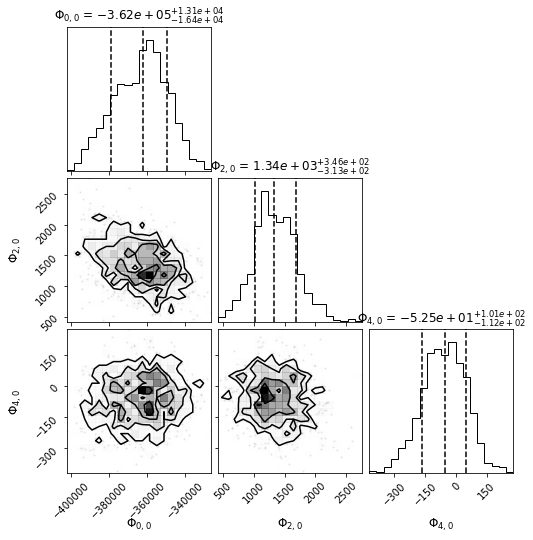

In [30]:
import corner

labels = ['$\Phi_{0,0}$','$\Phi_{2,0}$','$\Phi_{4,0}$']
fig= corner.corner(coeff_array[:,1:], labels=labels, show_titles=True, quantiles=[0.16, 0.5, 0.84],
                       title_kwargs={"fontsize": 12}, title_fmt='.2e',
                      label_kwargs={"fontsize":12}, hist2d_kwargs={"fontsize":8})
#fig.suptitle('Coefficient Correlations at R = 13 kpc', fontsize=12)

fig.savefig('corner_test_icrs.png')

In [36]:
print("[1, 2]:", np.corrcoef(coeff_array[:,1], coeff_array[:,2]), sep="\n", end="\n\n")
print("[1, 3]:", np.corrcoef(coeff_array[:,1], coeff_array[:,3]), sep="\n", end="\n\n")
print("[2, 3]:", np.corrcoef(coeff_array[:,2], coeff_array[:,3]), sep="\n", end="\n\n")

[1, 2]:
[[ 1.         -0.38186149]
 [-0.38186149  1.        ]]

[1, 3]:
[[1.         0.09249058]
 [0.09249058 1.        ]]

[2, 3]:
[[ 1.         -0.12128024]
 [-0.12128024  1.        ]]



<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>